## 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import math

In [2]:
class world:

    def __init__(self, sidelength = 40, maxtime = 1000, npeople = 100, ninfected = 1, infectionsim = True, pspawn = .5, pdie = .5, multips = False, spawninf = .5, dieinf = .5, spawnnot = .5, dienot = .5):
        self.sidelength = sidelength
        self.maxtime = maxtime
        self.npeople = npeople
        self.ninfected = ninfected
        self.startinfected = ninfected
        self.grid_infected = np.zeros((sidelength, sidelength), dtype=int)
        self.grid_not = np.zeros((sidelength, sidelength), dtype=int)

        self.day = 0
        self.dayallinfected = 0
        self.infectionsim = infectionsim
        self.pspawn = pspawn
        self.pdie = pdie

        self.multips = multips
        self.spawninf = spawninf
        self.dieinf = dieinf
        self.spawnnot = spawnnot
        self.dienot = dienot
        
        self.startup()
        
    def startup(self):
        for i in range(self.npeople - self.ninfected):
            x = np.random.randint(0,self.sidelength)
            y = np.random.randint(0,self.sidelength)
            self.grid_not[x][y] += 1
        for i in range(self.ninfected):
            x = np.random.randint(0,self.sidelength)
            y = np.random.randint(0,self.sidelength)
            self.grid_infected[x][y] +=1
   
    def step(self):
        # Moves first
        # 2x 2D arrays, calculate moves and then correlate for infections
        new_infected = np.zeros((self.sidelength, self.sidelength), dtype=int)
        new_not = np.zeros((self.sidelength, self.sidelength), dtype=int)
        for x in range(self.sidelength):
            for y in range(self.sidelength):
                
                # Moves
                if self.grid_infected[x][y] > 4:
                    inhabitants = self.grid_infected[x][y]

                    new_infected[x][y] += np.floor(inhabitants *.2) 
                    new_infected[x][(y+1) % self.sidelength] += np.floor(inhabitants *.2)
                    new_infected[x][(y-1) % self.sidelength] += np.floor(inhabitants *.2)
                    new_infected[(x+1) % self.sidelength][y] += np.floor(inhabitants *.2)
                    new_infected[(x-1) % self.sidelength][y] += np.floor(inhabitants *.2)
                    
                    diff = int(inhabitants - 5 *  np.floor(inhabitants * .2))
                    self.move_singles(new_infected, diff, x, y)

                else:
                    self.move_singles(new_infected, self.grid_infected[x][y], x, y)

                if self.grid_not[x][y] > 4:
                    inhabitants = self.grid_not[x][y]

                    new_not[x][y] += np.floor(inhabitants *.2) 
                    new_not[x][(y+1) % self.sidelength] += np.floor(inhabitants *.2)
                    new_not[x][(y-1) % self.sidelength] += np.floor(inhabitants *.2)
                    new_not[(x+1) % self.sidelength][y] += np.floor(inhabitants *.2)
                    new_not[(x-1) % self.sidelength][y] += np.floor(inhabitants *.2)
                    
                    diff = int(inhabitants - 5 *  np.floor(inhabitants * .2))
                    self.move_singles(new_not, diff, x, y)

                else:
                    self.move_singles(new_not, self.grid_not[x][y], x, y)
        
        # Moved everyone
        self.grid_infected = new_infected
        self.grid_not = new_not

        # Infections
        for x in range(self.sidelength):
            for y in range(self.sidelength):

                # Basic infection
                if self.infectionsim and not self.multips:
                    if self.grid_infected[x][y] > 0:
                        self.infect_all(x,y)
                # Different P() per species
                elif self.multips:
                    self.multimeet(x, y)
                # Same P() for both groups
                else:
                    self.meet(x, y)

    def move_singles(self, grid, inhabitants, x, y):
        if inhabitants == 0:
            return
        
        for i in range(inhabitants):
            dir = np.random.randint(1,6)
            #Up
            if dir == 1:
                y += 1
            #R
            elif dir == 2:
                x += 1
            #Down
            elif dir == 3:
                y -= 1
            #Left
            elif dir == 4:
                x -= 1
            #still
            elif dir == 5:
                pass

            #Wrap
            x = x % self.sidelength
            y = y % self.sidelength
            # Move
            grid[x][y] += 1

    def infect_all(self, x, y):
        self.grid_infected[x][y] += self.grid_not[x][y]
        self.ninfected += self.grid_not[x][y]
        self.grid_not[x][y] = 0

    def run(self):
        stats = {}
        while self.maxtime > 0:
            self.step()
            self.stats()
            self.maxtime -= 1
            self.day += 1
            stats[self.day] = (self.ninfected, self.npeople - self.ninfected)
        return stats

    def untilall(self):
        tracker = []
        while self.ninfected != self.npeople:
            self.step()
            self.stats()
            self.day += 1
            tracker.append(self.ninfected)
            if self.day == self.maxtime:
                print('Max time, infecteds:', self.ninfected, ', people:',self.npeople)
                break
        return tracker
        
    def stats(self):
        if self.dayallinfected == 0 and self.ninfected == self.npeople:
            self.dayallinfected = self.day

    # Inelegant but efficient for larger populations
    def meet(self, x, y):
        
        infs = self.grid_infected[x][y]
        nots = self.grid_not[x][y]

        if (nots + infs) < 2:
            return

        # Different processes for combos of species/counts on each square, more efficient for larger numbers
        if nots == 0 and infs > 9:
            add = round(self.pspawn * infs)
            self.grid_infected[x][y] += add
            self.ninfected += add
            self.npeople += add

        elif infs == 0 and nots > 9:
            add = round(self.pspawn * nots)
            self.grid_not[x][y] += add
            self.npeople += add
            
        
        elif infs > 9 and nots > 9:
            dead_inf = round(self.pdie * infs)
            dead_not = round(self.pdie * nots)
            self.grid_not[x][y] -= dead_not
            self.grid_infected[x][y] -= dead_inf
            self.ninfected -= dead_inf
            self.npeople -= (dead_inf + dead_not)

        # Manual randomising rather than multiplicative for smaller numbers
        elif infs > 1 and nots == 0:
            add = 0
            for i in range(int(np.floor(infs/2))):
                if np.random.rand() < self.pspawn:
                    add += 1
            self.grid_infected[x][y] += add
            self.ninfected += add
            self.npeople += add

        elif nots > 1 and infs == 0:
            add = 0
            for i in range(int(np.floor(nots/2))):
                if np.random.rand() < self.pspawn:
                    add += 1
            self.grid_not[x][y] += add
            self.npeople += add
            
        else:
            # Different but small population
            dead_inf = 0
            dead_not = 0
            
            for i in range(infs):
                if np.random.rand() < self.pdie:
                    dead_inf += 1
            for i in range(nots):
                if np.random.rand() < self.pdie:
                    dead_not += 1

            self.grid_infected[x][y] -= dead_inf
            self.grid_not[x][y] -= dead_not
            
            self.ninfected -= dead_inf
            self.npeople -= (dead_inf + dead_not)
           
    def total_infecteds(self):
        return (np.sum(self.grid_infected))

    def total_nots(self):
        return ( np.sum(self.grid_not))

    # Same as meet() but with unique P() per species
    def multimeet(self, x, y):
        
        infs = self.grid_infected[x][y]
        nots = self.grid_not[x][y]
        
        if (nots + infs) < 2:
            return
        
        if nots == 0 and infs > 9:
            add = round(self.spawninf * infs)
            self.grid_infected[x][y] += add
            self.ninfected += add
            self.npeople += add

        elif infs == 0 and nots > 9:
            add = round(self.spawnnot * nots)
            self.grid_not[x][y] += add
            self.npeople += add
            
        
        elif infs > 9 and nots > 9:
            dead_inf = round(self.dieinf * infs)
            dead_not = round(self.dienot * nots)
            self.grid_not[x][y] -= dead_not
            self.grid_infected[x][y] -= dead_inf
            self.ninfected -= dead_inf
            self.npeople -= (dead_inf + dead_not)

        elif infs > 1 and nots == 0:
            add = 0
            for i in range(int(np.floor(infs/2))):
                if np.random.rand() < self.spawninf:
                    add += 1
            self.grid_infected[x][y] += add
            self.ninfected += add
            self.npeople += add

        elif nots > 1 and infs == 0:
            add = 0
            for i in range(int(np.floor(nots/2))):
                if np.random.rand() < self.spawnnot:
                    add += 1
            self.grid_not[x][y] += add
            self.npeople += add

        else:
            # Different but small pop
            for i in range(infs):
                prob = np.random.rand()
                if prob < self.dieinf:
                    self.grid_infected[x][y] -= 1
                    self.ninfected -= 1
                    self.npeople -= 1
            for i in range(nots):
                prob = np.random.rand()
                if prob < self.dienot:
                    self.grid_not[x][y] -= 1
                    self.npeople -= 1
   

In [3]:
sidelength = 40
maxtime = 1000
npeople = 100
ninfected = 1

data = []
times = []

runs = 100
print('Running', runs, 'times...\n')
for x in range(1,runs+1):
    aus = world(sidelength, maxtime, npeople, ninfected, infectionsim=True)
    output = aus.untilall()
    times.append(len(output))
    data.append(output)
    if x % 10 == 0:
        print('Run', x, 'times.')


Running 100 times...

Run 10 times.
Run 20 times.
Run 30 times.
Run 40 times.
Run 50 times.
Run 60 times.
Run 70 times.
Run 80 times.
Run 90 times.
Run 100 times.


In [4]:
mean = np.mean(times)
sem = np.std(times) / np.sqrt(len(times))
ci = 1.96 * sem
lower = mean - ci
upper = mean + ci
mean, round(lower,2), round(upper,2), ci

(410.73, 398.43, 423.03, 12.304081831392379)

## 1.1 Time to Complete Infection
From default values sidelength = 40, maxtime = 1000, npeople = 100, ninfected = 1, the average number of days until 100% infection is approximately 400 (95% CI [388, 412])

## 1.2 Plotting Average Time to Complete Infection

In [5]:
maxlen = max(len(run) for run in data)
counts = {}
for d in range(maxlen):
    counts[d] = 0
    datapoints = 0
    for output in data:
        if len(output) > d:
            counts[d] += output[d]
            datapoints += 1
    counts[d] /= datapoints


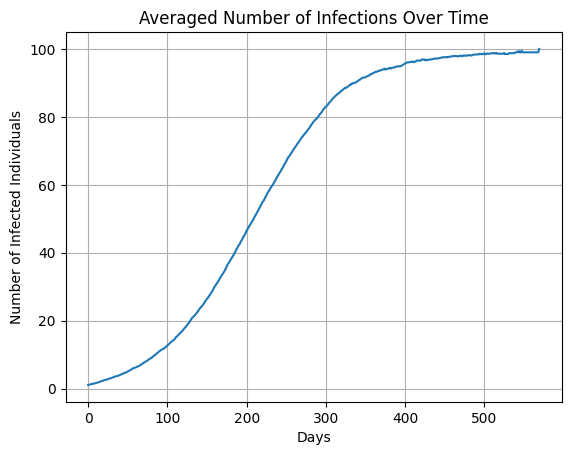

In [6]:
days = list(counts.keys())
infected_counts = list(counts.values())

plt.plot(days, infected_counts)
plt.xlabel('Days')
plt.ylabel('Number of Infected Individuals')
plt.title('Averaged Number of Infections Over Time')
plt.grid(True)
plt.show()

The above figure shows the average daily infected population for 100 test runs of the default simulation values. 

Given that most runs did not surpass 400 days, the line drawn is visibly rougher than the earlier smoothed datapoints, where a greater number of entries created a smoother curve. 

## 1.3 Halve the World

In [7]:
sidelength = 20 # Halved, 40/2
runs = 100
timeshalved = []

for x in range(1, runs+1):
    aus = world(sidelength=sidelength)
    timeshalved.append(len(aus.untilall()))
    if x % 10 == 0:
        print(x,"runs complete.")

mean = np.mean(timeshalved)
sem = np.std(timeshalved) / np.sqrt(len(timeshalved))
ci = 1.96 * sem
lower = mean - ci
upper = mean + ci
mean, round(lower,2), round(upper,2), ci

10 runs complete.
20 runs complete.
30 runs complete.
40 runs complete.
50 runs complete.
60 runs complete.
70 runs complete.
80 runs complete.
90 runs complete.
100 runs complete.


(89.98, 87.26, 92.7, 2.7179737735305687)

The halved sidelength = 20 resulted in a mean time to 100% infection of 89 days with 95% CI [86, 92], approximately 4 times quicker than the sidelength = 40 simulations. 

This result suggests that reducing the distance between individuals could massively increase the risk of infection, and cause much faster spread of disease. In the first simulation, there were 100 people in 1600 cells, but in this simulation there were the same number of people in 400 cells; giving a person-cell density 4 times greater. 

Obviously, this basic simulation does not account for anywhere near enough factors to be used as anything more than an indicative demonstration, but it is useful as a starting or reference point for more complex simulations.

## 1.4 Two Populations Spawning and Dying

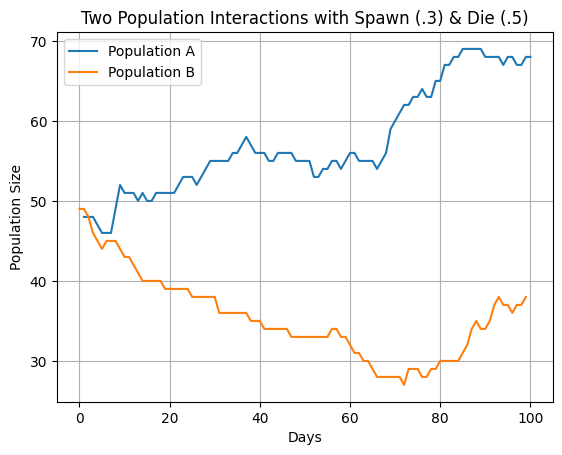

In [8]:
ninfected = 50
pspawn = .3
pdie = .5

w  = world(maxtime = 100, ninfected=ninfected, infectionsim=False, multips=False, pspawn=pspawn, pdie=pdie)
popdata = w.run()

days = list(popdata.keys())
ipopulation = []
nonpopulation = []
for val in days:
    ipopulation.append(popdata[val][0])
    nonpopulation.append(popdata[val][1])

plt.plot(days, ipopulation, nonpopulation)
plt.xlabel('Days')
plt.ylabel('Population Size')
plt.title('Two Population Interactions with Spawn (.3) & Die (.5)')
plt.grid(True)
plt.legend(['Population A','Population B' ])
plt.show()


## 1.5 Two Populations Spawning and Dying with Different Rates

Sim 1 done in 0.18801045417785645
Sim 2 done in 0.2667210102081299
Sim 3 done in 0.2028493881225586
Sim 4 done in 0.20012235641479492


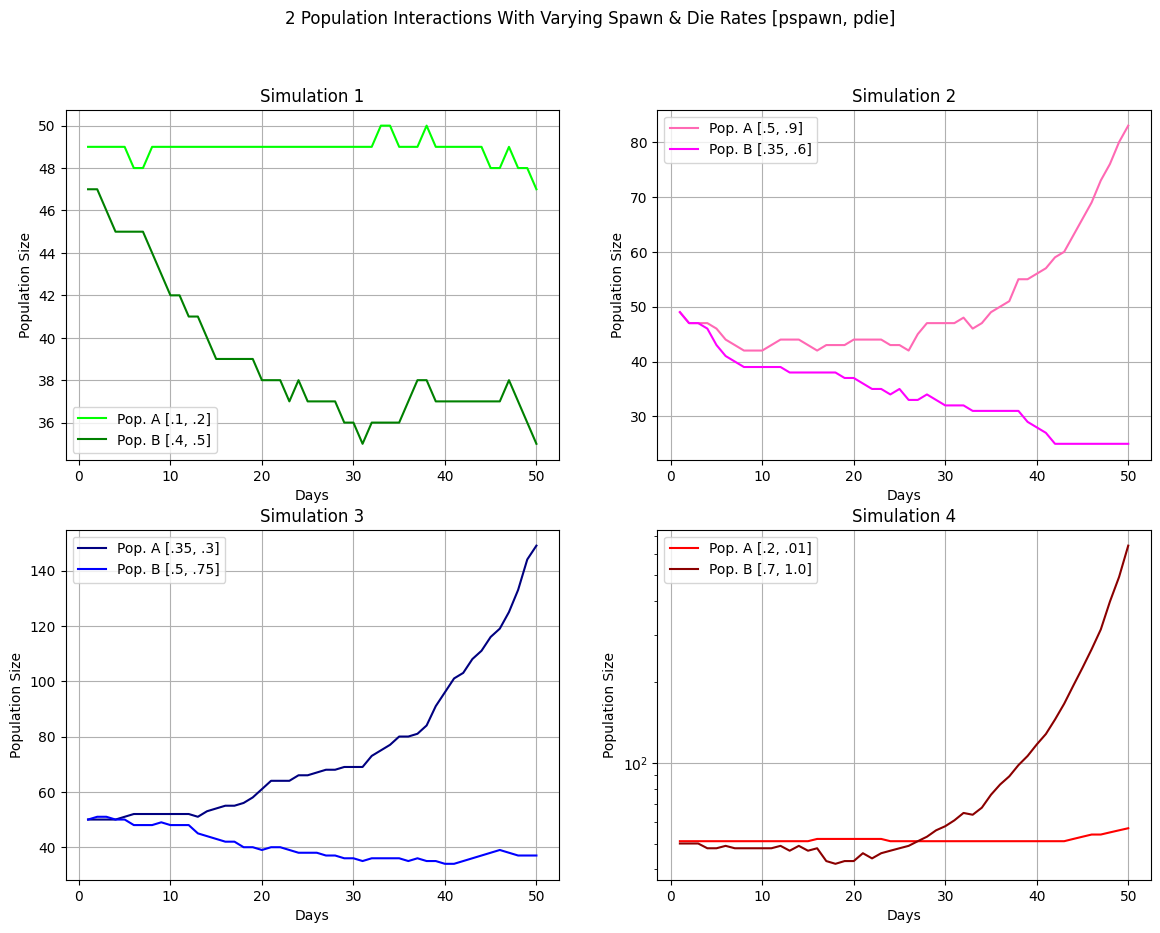

In [9]:
ndays = 50

# A slow grow, B medium grow
w1 = world(maxtime=ndays, ninfected=50, infectionsim=False,multips=True, spawninf=.1, spawnnot=.4, dieinf=.2, dienot=.5)
# A fast grow faster die, B medium grow fast die
w2 = world(maxtime=ndays, ninfected=50, infectionsim=False,multips=True, spawninf=.5, spawnnot=.35, dieinf=.7, dienot=.9)
# A A slow grow, B medium die
w3 = world(maxtime=ndays, ninfected=50, infectionsim=False,multips=True, spawninf=.4, spawnnot=.5, dieinf=.3, dienot=.7)
# A medium grow, B medium grow
w4 = world(maxtime=ndays, ninfected=50, infectionsim=False,multips=True, spawninf=.2, spawnnot=.7, dieinf=.01, dienot=1)

proc1 = [[],[]]
proc2 = [[],[]]
proc3 = [[],[]]
proc4 = [[],[]]

starttime = time.time()

out1 = w1.run()
print('Sim 1 done in', time.time() - starttime)
time1 = time.time()
out2 = w2.run()
print('Sim 2 done in', time.time() - time1)
time2 = time.time()
out3 = w3.run()
print('Sim 3 done in', time.time() - time2)
time3 = time.time()
out4 = w4.run()
print('Sim 4 done in', time.time() - time3)

outputs = [out1, out2, out3, out4]
days = list(out1.keys())
for d in days:
    proc1[0].append(out1[d][0])
    proc1[1].append(out1[d][1])
    proc2[0].append(out2[d][0])
    proc2[1].append(out2[d][1])
    proc3[0].append(out3[d][0])
    proc3[1].append(out3[d][1])
    proc4[0].append(out4[d][0])
    proc4[1].append(out4[d][1])



fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].plot(days, proc1[0], label='Pop. A [.1, .2]', c="lime")
ax[0, 0].plot(days, proc1[1], label='Pop. B [.4, .5]' , c="green")
ax[0, 0].set_title('Simulation 1')

ax[0, 1].plot(days, proc2[0], label='Pop. A [.5, .9]', c="hotpink")
ax[0, 1].plot(days, proc2[1], label='Pop. B [.35, .6]', c="magenta")
ax[0, 1].set_title('Simulation 2')

ax[1, 0].plot(days, proc3[0], label='Pop. A [.35, .3]', c="navy")
ax[1, 0].plot(days, proc3[1], label='Pop. B [.5, .75]', c="blue")
ax[1, 0].set_title('Simulation 3')

ax[1, 1].plot(days, proc4[0], label='Pop. A [.2, .01]', c="red")
ax[1, 1].plot(days, proc4[1], label='Pop. B [.7, 1.0]', c="darkred")
ax[1, 1].set_yscale('log')
ax[1, 1].set_title('Simulation 4')

for x in range(2): 
    for y in range(2):
        ax[x, y].grid(True)
        ax[x, y].legend()
        ax[x, y].set_xlabel("Days")
        ax[x, y].set_ylabel("Population Size")

fig.suptitle('2 Population Interactions With Varying Spawn & Die Rates [pspawn, pdie]')
plt.show()

The agent based model is run 4 times for 30 days, each time with different probabilities for spawning or death, depending on the encounter. 

The four simulations are characterised by and use the following parameters:

Simulation 1 has a slowly dying A population with minimal non-compensatory growth, and the same for the B population, albeit at a faster rate. The simulations for these parameters generally have both populations decreasing with the A population doing marginally better, although in some instances, initial growth can allow the B population to grow exponentially. Longer simulations may reveal more detail, and the eventual extinction of population A. 

Simulation 2's A population is spawning at a rate of .5, but dying faster, while it's B population is spawning more slowly and dying much more quickly. Most simulations show the A population slowly killing out the B population, as A's high death rate is not sufficiently impacted by B's mediocre spawn rate. It is notable that many simulations showed both populations dying out, although some showed population A skyrocketing with B becoming extinct.

Simulation 3 has parameters causing population A to grow and die at similar rates with overall growth, with the opposite for B, although with larger margins and values. There is a large degree of variability in the outcome for this simulation, with some runs having both populations remain steady, and some showing B growing exponentially, as A's growth rate is too low to spawn enough A individuals to kill B faster than B's spawn rate, even with compensatory death rate. 

Simulation 4 has a very steady, very slowly growing A population, and B population growing rapidly, while having a 100% death rate upon contact with A. Most runs show the B population managing to outgrow the deadly A population, although some have unlucky initial phases and take much longer to begin growing, with some trending towards extinction. Longer simulations are neccesary to properly understand the behaviour, and find if even with exponential B growth, if A is able to kill enough of the population later.

The current implementation of the simulation is extremely inefficient for populations exceeding 10^4, and so the simualtions have been limited to 30 days. Longer simulations may reveal more details about these observed trends. The 40x40 grid size, while still only starting with 100 agents, represents a relatively sparse simulated environment, with 1600 different cells for the 100 agents. 

The findings here largely agree with the findings of the ordinary differential equation (ODE) model, however, the variability in results of the simulations shows the lackings of the agent based model. The specific issues are likely derived from flawed implementation. An ODE would not be as influenced by random chance as this model is, and would provide a continuous, consistent description of the values, regardless of input parameters. However, an ODE is not capable of modelling the flukey nature of some of the simulations, where initial deaths or spawning can massively influence the trajectory of the populations, even where the parameters are designed to create a different outcome. 

## 2


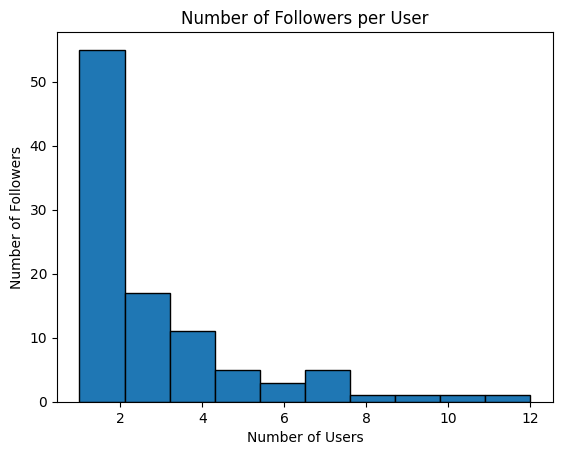

In [10]:
# Users join 1 by 1. They randomly follow 1 user, are followed randomly by 1 user, and follow one user based on p()
nusers = 100
follows = 0

network = [[] for u in range(nusers)]
popularities = []

def randuser(nusers):
    return np.random.randint(0,nusers)

def choosepopular(network, nusers, follows):
    follow = 0
    curmax = -1
    for u in range(nusers):
        p = len(network[u])/follows
        if p > curmax:
            curmax = p
            follow = u
    return follow

def popular(network, nusers, follows):
    counts = np.ones(nusers)
    for u in range(nusers):
        counts[u] = len(network[u])

    popularities = counts/follows
    
    follow = np.random.choice(np.arange(nusers), p=popularities)
    return follow
        
def startup(network, nusers, follows):
    for user in range(nusers):
        flag = True
        while flag:
            firstfollower = randuser(nusers)
            if firstfollower != user:
                network[user].append(randuser(nusers))
                follows += 1
                flag = False

        flag = True
        while flag:
            firstfollow = randuser(nusers)
            if firstfollow != user:
                network[firstfollow].append(user)
                follows += 1
                flag = False
        network[popular(network, nusers, follows)].append(user)
        follows += 1
        

startup(network, nusers, follows)

output = np.zeros(nusers)
for x in range(nusers):
    output[x] = len(network[x])

plt.hist(output, edgecolor='black')
plt.ylabel('Number of Followers')
plt.xlabel('Number of Users')
plt.title('Number of Followers per User')
plt.show()


## 2.1 Network Follower Distribution

The distribution shown is a right-skewed distribution. This indicates that most of the users do not have alot of followers, while a small proportion of the users have many followers. This is evident from the histogram, which shows significant proportions of the users having less than 4 followers, while only a handful of users have more than 8. Some simulations are even more extreme, with up to 75 users have a single follower, and a single user have 25 followers.  

This network is a directed graph, in which the relationships between entities is directional, as a user might not follow one of their followers. This is evident from the construction of the network, in which followers are assigned randomly, and can only be reciprocated randomly. 

## 2.2 Messages in the Network

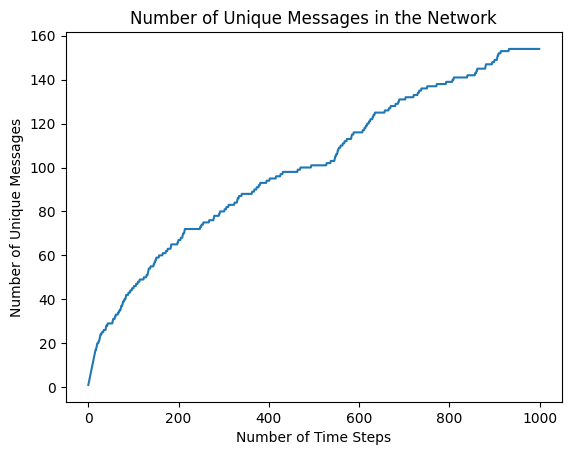

In [11]:
mu = .1
steps = 1000
contented = []
tweets = np.zeros(steps)

for step in range(steps):
    if step != 0:
        tweets[step] += tweets[step-1]

    uid = randuser(nusers)
    user = network[uid]
    seensomething = False
    for follow in user:
        if follow in contented:
            seensomething = True
            break
    if not seensomething:
        contented.append(uid)
        tweets[step] += 1
    else:
        newcontent = np.random.rand()
        if newcontent < mu:
            tweets[step] += 1
        contented.append(uid)

plt.plot(tweets)
plt.xlabel('Number of Time Steps')
plt.ylabel('Number of Unique Messages')
plt.title('Number of Unique Messages in the Network')
plt.show()

## 2.3 Formerly Known as Twitter

In [12]:
filename = 'all_climate_daily_hashtags.csv'
data = pd.read_csv(filename, index_col=0)

In [13]:
# Have a look at the data structure
data

,11/11/2019,12/11/2019,13/11/2019,14/11/2019,15/11/2019,16/11/2019,17/11/2019,18/11/2019,19/11/2019,20/11/2019,...,4/03/2020,5/03/2020,6/03/2020,7/03/2020,8/03/2020,9/03/2020,10/03/2020,11/03/2020,12/03/2020,13/03/2020
00s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
012172b3a9d75f7f9c2ccb720a44e9e4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01rad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
021disrupt19,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0308꿈모아,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
𝗔𝗨𝗦𝗧𝗥𝗜𝗔𝗟𝗕𝗨𝗥𝗡𝗦,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝗕𝗿𝗮𝗱𝗡𝗼𝗿𝗿𝗶𝗻𝗴𝘁𝗼𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝗘𝗨,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
𝗙𝗼𝘀𝘀𝗶𝗹𝗙𝘂𝗲𝗹𝗜𝗻𝗱𝘂𝘀𝘁𝗿𝘆,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.3 Total and Unique Daily Hashtags

Note the x-axis labels have been made more sparse for aesthetics, but the data is actually plotted for every day. 

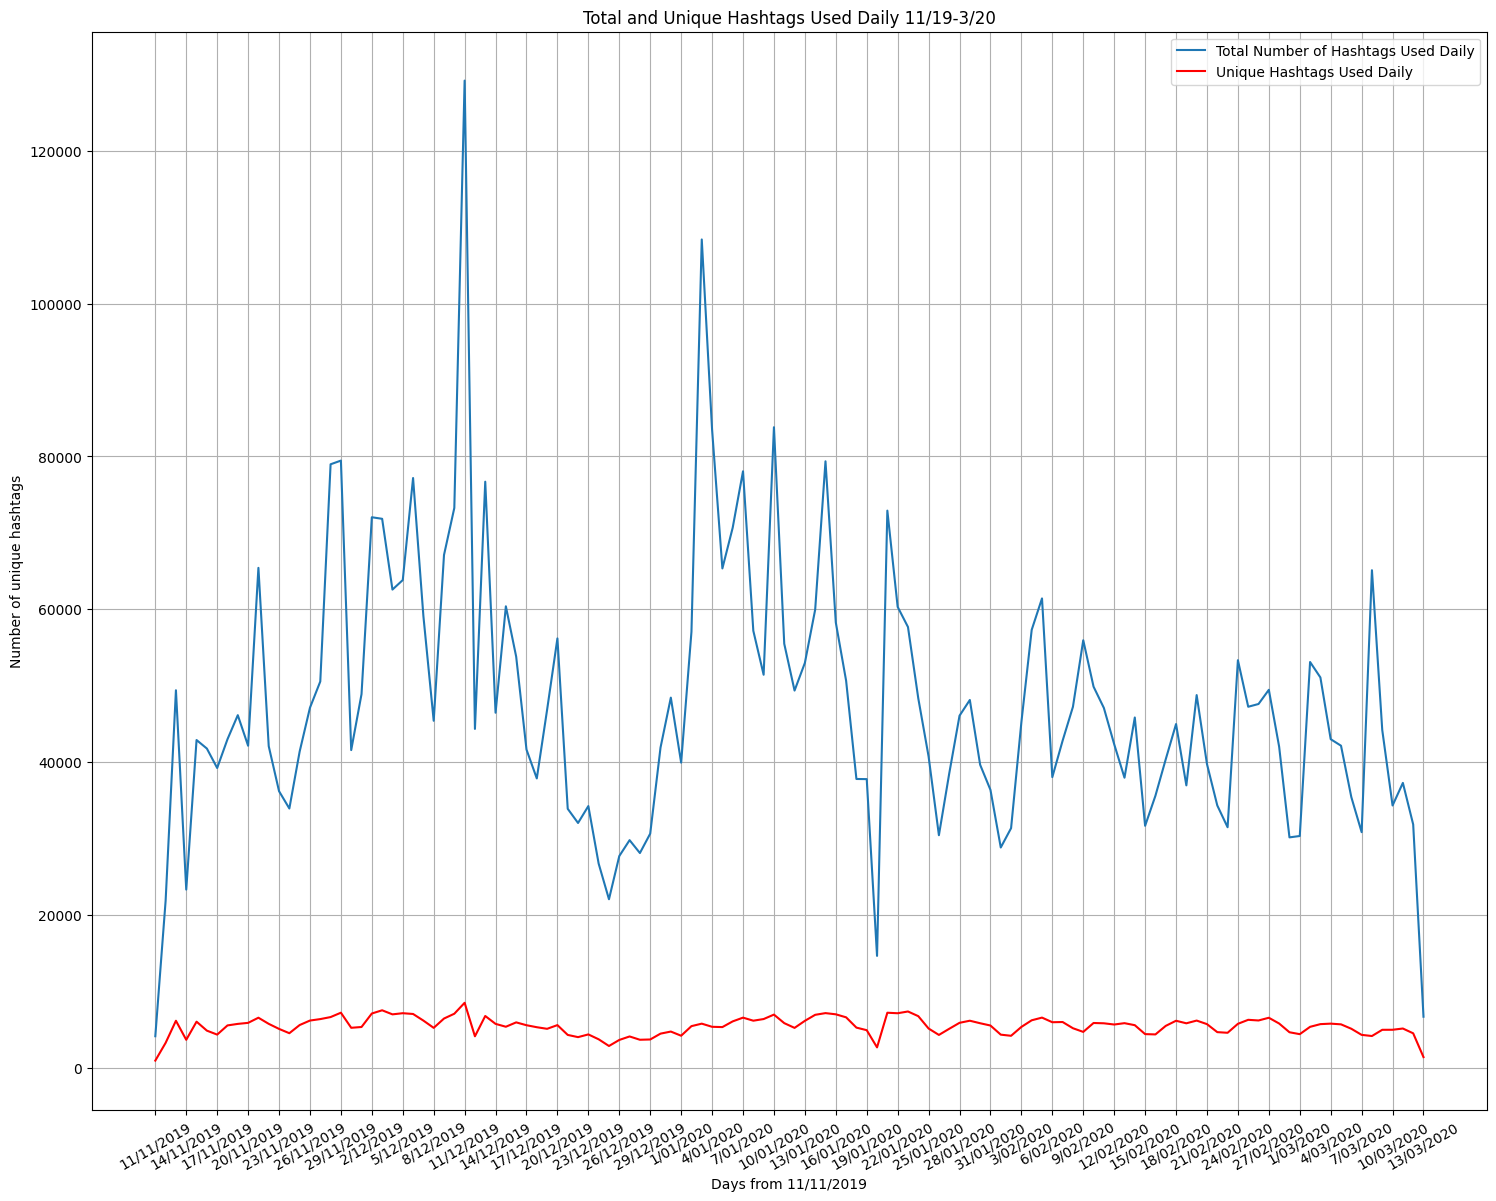

In [14]:
# Total
perday = np.sum(data, axis=0)
plt.figure(figsize=(18,14))
plt.plot(perday, label='Total Number of Hashtags Used Daily')
plt.ylabel('Number of Hashtags')
plt.xlabel('Date')

# Unique hashtags
uniques = np.count_nonzero(data, axis=0)
dates = list(data.columns)
plt.plot(dates, uniques, c ='red', label='Unique Hashtags Used Daily')
plt.xlabel('Days from 11/11/2019')
plt.ylabel('Number of unique hashtags')

# x-axis labels
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::3])
plt.xticks(rotation=30)

plt.title("Total and Unique Hashtags Used Daily 11/19-3/20")
plt.grid()
plt.legend()
plt.show()

The provenance of the dataset has not been provided, so the following is based on the assumption of Australia only data. 

The plots of unique and total daily hashtag use reflect the echo-chamber nature of social media, where a significant spike in activity and hashtag use, shown in blue, does not correspond with diverse or unique viewpoints and discussion, as the red line, denoting unique hashtag count, remains largely steady. Notably the red plot does fluctuate when there are massive dips in total hashtag counts, as can be seen around Christmas 2019. The significant drop around January 20 is of uncertain cause, although that date did have a catastrophic hailstorm hit the ACT, which may have impacted political activity. Some activity patterns could also relate to the Australian Open, which took place from 14/1 to 2/2. Even with these events, the massive disparities between unique and total hashtags imply that a substantial portion of activity is simply retweeting or echoing existing ideas and content. 

The model obtained in 2.2 is not directly comparable to the results obtained above, as a cumulative summation of messages in a network is not useful to refer to a daily count of hashtags, unique or total. Therefore, another plot has been generated below, which displays the cumulative summation of daily unique hashtags from the Twitter dataset. The plots are not massively alike, as the simulated network can be seen to have a much steeper initial growth, while the Twitter data is far steadier in its growth. This can perhaps be attributed to the scale of Twitter, whereby for such a massive platform, the effects of super-users, with disproportionately large followings and therefore reach, are minimised. However, on the simulated network, with only 100 users, a handful of users with more than 10 followers can make a visible and quantifiable impact on message count through reposting.
 
The comparison is also impacted by Twitter's infamous algorithms, which recommend content from other users based on sophisticated models to heighten engagement, and therefore advertising revenue. These algorithms are critical to the aforementioned echo-chamber of social media networks, and are not paralelled in the simulation, reducing their comparability. 

The simulation implies that there is some tapering of the number of unique messages, and that there are a handful of users with outsized influence based on their follower count. In contrast, the number of unqiue Twitter hashtags appears linear, with minimal impact from any particular users or groups of users, and no tapering. The simulation simply does not appear to have the scale to be comparable to the Twitter data, which also does not have the granularity of informing the analyst of new vs re-Tweeted messages or hashtags. Therefore, while the plots and data are complementary in that they refer to the same field, they are not directly comparable. 

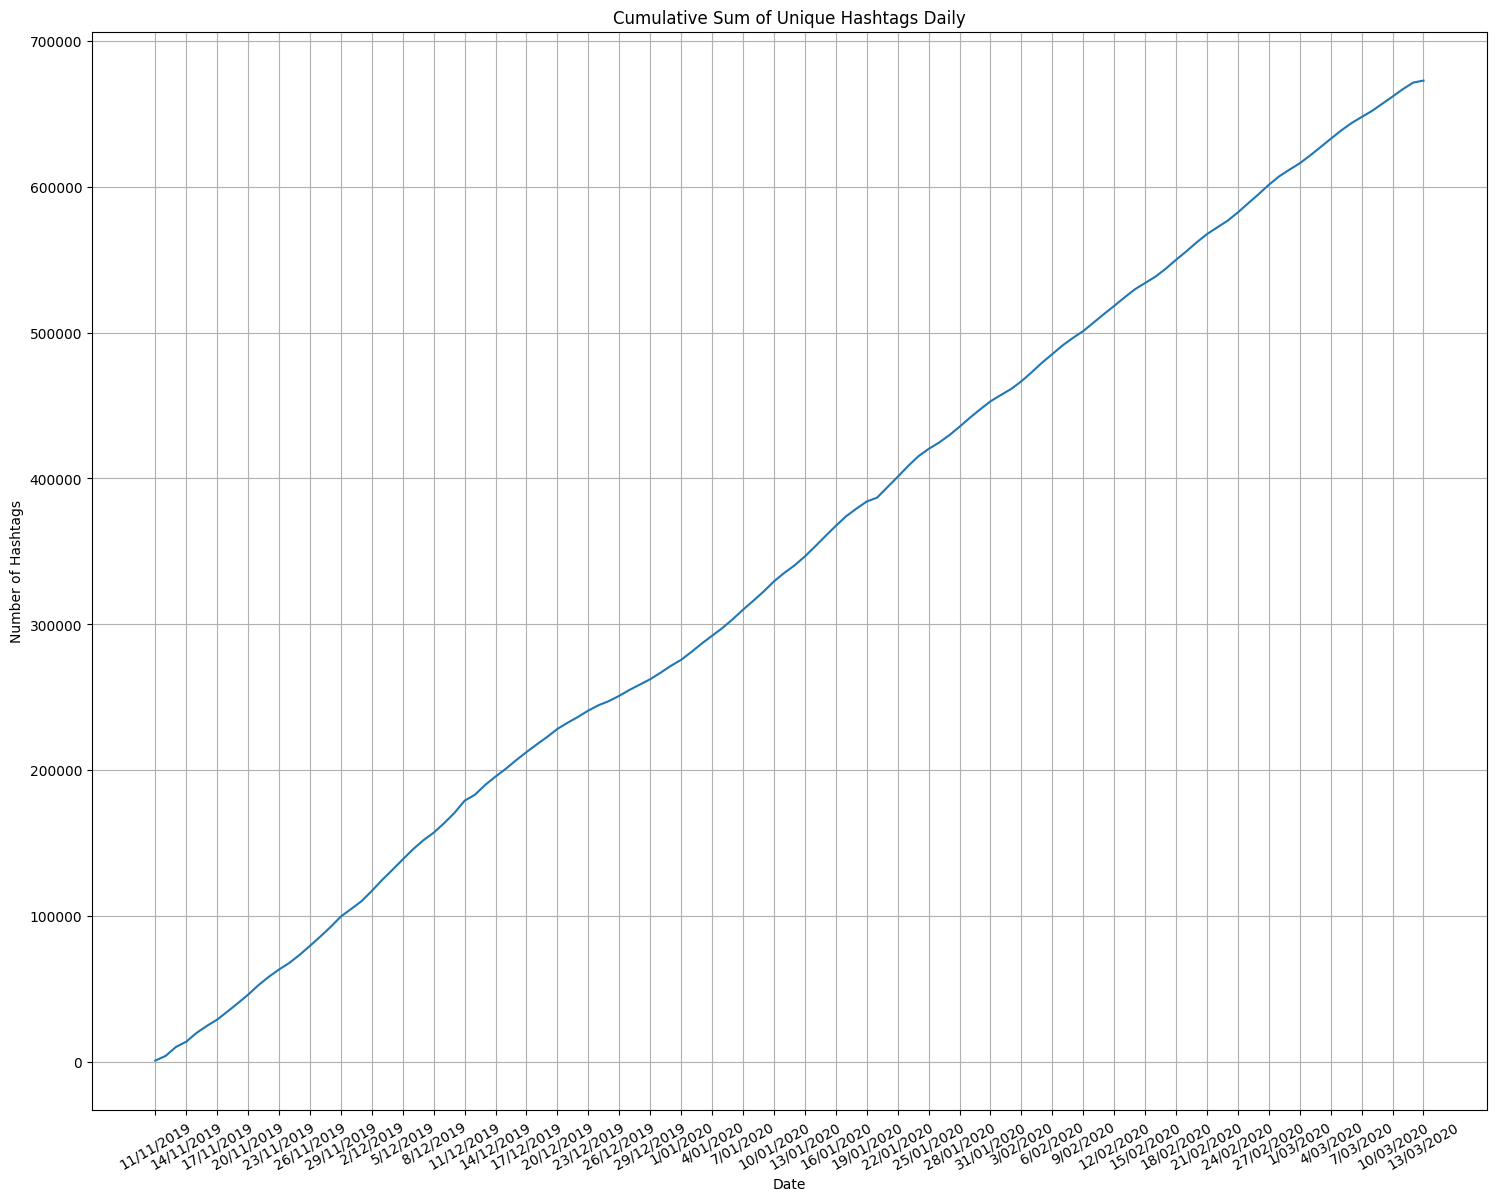

In [15]:
summed = np.cumsum(uniques)
plt.figure(figsize=(18,14))

plt.plot(dates,summed)
plt.title('Cumulative Sum of Unique Hashtags Daily')
plt.xlabel('Date')
plt.ylabel('Number of Hashtags')
ax = plt.gca()
plt.xticks(rotation=30)
ax.set_xticks(ax.get_xticks()[::3])
plt.grid()
plt.show()